# <center> Training Pre-Trained VGG-19
## <center> To Classify Duck & Chicken Images

#### Importing Requisite packages

In [117]:
import os, sys, random, time, copy, cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights, vgg19, VGG19_Weights
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

#### Setting directories

In [118]:
data_folder = "/Users/Soham/Documents/CMI-SEM-4/AML/data/data_assign5/cnn_data"
cl_names = os.listdir(data_folder)

##### Checking if CUDA/MPS is available

In [119]:
use_gpu = torch.cuda.is_available()
use_gpu_mps = torch.backends.mps.is_available()
if use_gpu:
    print('Using GPU: ', use_gpu)
    device = torch.device("cuda")
    
elif use_gpu_mps == True:
    print('Using mps GPU: ', use_gpu_mps)
    device = torch.device("mps")
else:
    print('Using GPU: ', use_gpu)
    device = torch.device("cpu")

Using mps GPU:  True


##### Setting the frequency of printing training stats

In [120]:
freq_print = 25

##### Loading data file paths (400 each for Chicken and Duck images)

In [121]:
def load_paths_from_folder(data_path):
    label_names = os.listdir(data_path)
    labels = list(range(len(label_names)))
    label_dict = {}
    for label in labels:
        label_dict[label] = label_names[label]

    file_paths = []
    for label in labels:
        i = 0
        for file in os.listdir(os.path.join(data_folder, label_dict[label])):
            file_paths.append((os.path.join(data_folder, label_dict[label], file), label))
            i += 1
            if i == 400:
                break

    random.shuffle(file_paths)

    train_num = int(0.6*len(file_paths))
    val_num = int(0.25*len(file_paths))

    train_list, val_list, test_list = file_paths[:train_num], file_paths[train_num:train_num+val_num], file_paths[train_num+val_num:]

    return train_list, val_list, test_list, label_dict

train_list, val_list, test_list, label_dict = load_paths_from_folder(data_folder)

len(train_list), len(val_list), len(test_list)

(480, 200, 120)

##### Defining Channel Mean and Std values for Imagenet dataset

In [122]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

##### Defining Data Transforms

In [123]:
data_transforms = {
	'train': transforms.Compose([
		transforms.RandomHorizontalFlip(),  # simple data augmentation
		transforms.RandomVerticalFlip(),	# simple data augmentation
		transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)]),

	'val': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
 
	'test': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	])
}

##### Defining a dataloader class extending the Dataset Class

In [124]:
class dataloader(Dataset):
	"""
	Dataset class to read img file from filepath 
	and return Pillow Image object with its label_id
	"""
	def __init__(self, list1, transform=None):
		self.list1 = list1
		self.transform = transform
	
	def __getitem__(self, index):
		list2 = self.list1[index]
		lab = int(list2[1])
		png = Image.open(list2[0]).convert('RGB') # ori: RGB, do not convert to numpy, keep it as PIL image to apply transform
		png = png.resize((224,224))

		if self.transform:
			png = self.transform(png)

		return png, lab

	def __len__(self):
		return len(self.list1)

##### Creating Dataset and DataLoader objects for all three lists

In [125]:
batch_size = 16

train_set = dataloader(train_list, transform = data_transforms['train'])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

val_set = dataloader(val_list, transform = data_transforms['val'])
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

test_set = dataloader(test_list, transform = data_transforms['test'])
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)

##### Defining a function to run validation 

In [126]:
# Function to run evaluation for a model on a given dataloader object
def run_validation(model, criterion, val_loader):
	model.eval()
	pred_labels = []
	orig_labels = []

	ntotal = 0
	running_loss = 0.0
	with torch.no_grad():
		for ix, batch in enumerate(val_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output
			
			_, preds = torch.max(output.data, 1)

			loss = criterion(output, targets)
			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)

			targets = torch.squeeze(targets).data.cpu().tolist()
			orig_labels = orig_labels + targets

			preds = torch.squeeze(preds).data.cpu().tolist()
			pred_labels = pred_labels + preds
	
	orig_labels = np.array(orig_labels).reshape(-1,1)
	pred_labels = np.array(pred_labels).reshape(-1,1)

	val_loss = running_loss/ntotal
	val_acc = accuracy_score(orig_labels, pred_labels)
	val_f1 = f1_score(orig_labels, pred_labels, average='macro')

	return val_loss, val_acc, val_f1, orig_labels, pred_labels

##### Defining a function to plot train-validation loss

In [127]:
def plot_tra_val_loss(tra_val_loss):
	epochs = list(range(1,len(tra_val_loss)+1))
	train_loss = [x[0] for x in tra_val_loss]
	val_loss = [x[1] for x in tra_val_loss]
	plt.plot(epochs, train_loss, label='Train Loss')
	plt.plot(epochs, val_loss, label='Validation Loss')
	plt.title('Training and Validation Loss per epoch')
	plt.ylabel('Loss')
	plt.xlabel('Epochs')
	plt.legend()
	plt.show()

##### Defining a function to train the model

In [128]:
def run_training(model, criterion, num_epochs, batch_size, lr, check_after, trainer = 'sgd', train_loader = train_loader, val_loader = val_loader): 
	best_f1 = 0
	best_epoch = 0
	train_val_loss_epoch = []
	start_training = time.time()

	for epoch in range(num_epochs):

		### TRAINING ###
		start = time.time()

		if epoch < num_epochs//6: lr = lr
		elif epoch < num_epochs//3: lr = lr/2
		elif epoch < num_epochs//2: lr = lr/4
		elif epoch < 3*(num_epochs//4): lr = lr/10
		else: lr = lr/20

		if epoch > 2:
			for param in model.parameters():
				param.requires_grad = True


		if trainer == 'adam':
			optimizer = optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
		elif trainer == 'sgd':
			optimizer = optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9, weight_decay=1e-4)
		else:
			raise Exception('Select optimiser (trainer) as adam or sgd')
		
		print('Epoch {}/{}'.format(epoch + 1, num_epochs))
		print('lr: {:.6f}'.format(lr))
		print('-' * 50)

		model.train()
		ntotal = 0
		running_loss = 0.0
		running_corrects = 0
		for ix, batch in enumerate(train_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)

			optimizer.zero_grad()
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output
			
			_, preds = torch.max(output.data, 1)
			loss = criterion(output, targets)
			loss.backward()
			optimizer.step()

			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)
			running_corrects += torch.sum(preds == targets.data)

			if (ix + 1) % freq_print == 0:
				print('| Epoch:[{}][{}/{}]\tTrain_Loss: {:.4f}\tAccuracy: {:.4f}\tTime: {:.2f} mins'.format(
					epoch + 1, ix + 1, len(train_loader.dataset)//batch_size, running_loss/ntotal, 
					running_corrects.item()/ntotal, (time.time() - start)/60.0))

			# sys.stdout.flush()

		### VALIDATION ###
		if (epoch + 1) % check_after == 0:
			model.eval()
			start = time.time()
			val_loss, val_acc, val_f1, orig_labels, pred_labels = run_validation(model, criterion, val_loader = val_loader)
			train_val_loss_epoch.append([running_loss/ntotal, val_loss])
			print("Epoch: {}/{}\tVal_Loss: {:.4f}\tAccuracy: {:.4f}\tF1-score: {:.4f}\t{:.3f}mins".format(
					(epoch + 1), num_epochs, val_loss, val_acc, val_f1, (time.time() - start)/60.0))
			start = time.time()

			# Save model if auc best auc score is acheived (yet)
			if val_f1 > best_f1:
				print('Saving model')
				best_f1 = val_f1
				best_epoch = epoch
				best_model = copy.deepcopy(model)
				state = {
					'model': best_model,
					'auc': best_f1,
					'lr': lr,
					'saved_epoch': epoch,
				}

				save_point = os.path.join('/Users/Soham/Documents/CMI-SEM-4/AML/src/models/checkpoints')
				if not os.path.isdir(os.path.join(save_point)):
					os.mkdir(save_point)

				saved_model_name = 'VGG19'
				torch.save(state, os.path.join(save_point, saved_model_name + '_' + str(round(best_f1,3)) + '_' + str(epoch) + '.t7'))
				
			print('=======================================================================')

	time_elapsed = time.time() - start_training
	print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
	print('Best validation F1 score: {:4f} at epoch: {}'.format(best_f1, best_epoch))

	plot_tra_val_loss(train_val_loss_epoch)
	return train_val_loss_epoch

##### Loading a pre-trained VGG-19 model, trained on ImageNet dataset

In [129]:
# model = efficientnet_b7(weights= EfficientNet_B7_Weights.DEFAULT)
model = vgg19(weights = VGG19_Weights.DEFAULT)

# Locking all Parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

# Changing last layer of model from 1000 classes to 2 classes
num_in = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_in, 2)

# Newly added layer has unlocked parameters
# The rest of the parameters will be unlocked after the 3rd epoch
model.eval()
model.to(device)

# print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

##### Training the model

Start training ... 
Epoch 1/25
lr: 0.000100
--------------------------------------------------
| Epoch:[1][25/30]	Train_Loss: 0.6380	Accuracy: 0.6125	Time: 0.11 mins
Epoch: 1/25	Val_Loss: 0.2844	Accuracy: 0.9300	F1-score: 0.9299	0.046mins
Saving model
Epoch 2/25
lr: 0.000100
--------------------------------------------------
| Epoch:[2][25/30]	Train_Loss: 0.3837	Accuracy: 0.8350	Time: 0.09 mins
Epoch: 2/25	Val_Loss: 0.2027	Accuracy: 0.9550	F1-score: 0.9549	0.040mins
Saving model
Epoch 3/25
lr: 0.000100
--------------------------------------------------
| Epoch:[3][25/30]	Train_Loss: 0.3351	Accuracy: 0.8825	Time: 0.09 mins
Epoch: 3/25	Val_Loss: 0.1665	Accuracy: 0.9550	F1-score: 0.9549	0.042mins
Epoch 4/25
lr: 0.000100
--------------------------------------------------
| Epoch:[4][25/30]	Train_Loss: 0.2586	Accuracy: 0.8950	Time: 0.31 mins
Epoch: 4/25	Val_Loss: 0.1368	Accuracy: 0.9600	F1-score: 0.9599	0.039mins
Saving model
Epoch 5/25
lr: 0.000050
-----------------------------------------

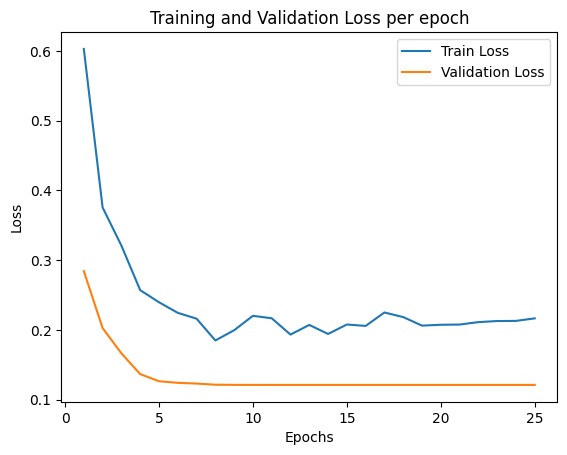

In [130]:
print('Start training ... ')
criterion = nn.CrossEntropyLoss().to(device)
train_val_loss = run_training(model=model, criterion=criterion, num_epochs=25, batch_size=batch_size, lr=1e-4, 
             check_after=1, train_loader=train_loader, val_loader=val_loader)

In [131]:
# Function to run evaluation for a model on a given dataloader object
def run_test(model, criterion, test_loader):
	model.eval()
	pred_labels = []
	orig_labels = []

	ntotal = 0
	running_loss = 0.0
	with torch.no_grad():
		for ix, batch in enumerate(test_loader):
			inputs, targets = batch

			inputs = inputs.to(torch.float).to(device)
			targets = targets.to(torch.long).to(device)
			output = model(inputs)
			if type(output) == tuple:
				output,_ = output
			
			_, preds = torch.max(output.data, 1)

			loss = criterion(output, targets)
			ntotal += output.size(0)
			running_loss += loss.item() * output.size(0)

			targets = torch.squeeze(targets).data.cpu().tolist()
			orig_labels = orig_labels + targets

			preds = torch.squeeze(preds).data.cpu().tolist()
			pred_labels = pred_labels + preds
	
	orig_labels = np.array(orig_labels).reshape(-1,1)
	pred_labels = np.array(pred_labels).reshape(-1,1)

	test_loss = running_loss/ntotal
	test_acc = accuracy_score(orig_labels, pred_labels)
	test_f1 = f1_score(orig_labels, pred_labels, average='macro')

	return test_loss, test_acc, test_f1, orig_labels, pred_labels

In [132]:
test_loss, test_acc, test_f1, orig_labels, pred_labels = run_test(model, criterion, test_loader)
print("The test accuracy is given by {:.4f}".format(test_acc))

The test accuracy is given by 0.9667


In [133]:
def cr_two_dg_images(images, labels):
    new_images = torch.empty((images.size(0)*images.size(0), images.size(1), images.size(2), images.size(3)*2))
    new_labels = torch.empty(labels.size(0)*images.size(0))
    for i in range(images.size(0)):
        for j in range(images.size(0)):
            img = torch.cat((images[i],images[j]), dim=2)
            lab = labels[i]*10 + labels[j]
            new_images[i*10 + j] = img
            new_labels[i*10 + j] = lab

    return new_images, new_labels.to(int)

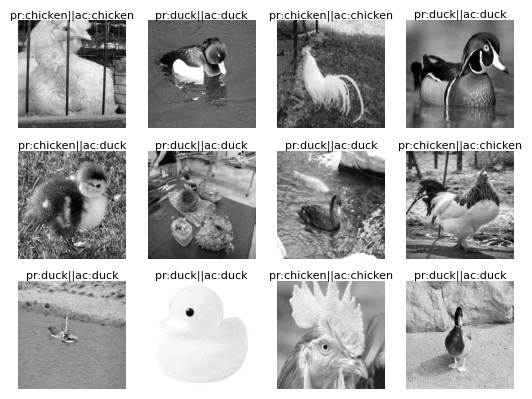

In [135]:
for ix, data in enumerate(test_loader):
    inputs,labels = data
    inputs_tensor = inputs.to(torch.float).to(device)
    labels = labels.to(torch.long).to(device)
    output = model(inputs_tensor)
    _, preds = torch.max(output.data, 1)
    break

def disp_images(img_data,act_label,lab_data, img_num): 
    total = img_num
    if np.sqrt(img_num) != int(np.sqrt(img_num)):
        col = int(np.sqrt(img_num)) + 1 
    else:
        col = int(np.sqrt(img_num))
    rows = total // col
    if total % col != 0:
        rows += 1

       
    fig = plt.figure(1)
    fig.tight_layout()
    for k in range(total):
        prediction = 'pr:chicken' if lab_data[k].item() == 1 else 'pr:duck'    
        labels = 'chicken' if act_label[k].item() == 1 else 'duck' 
        ax = fig.add_subplot(rows,col,k+1)
        ax.set_title(prediction + '||ac:'+ labels, size=8, pad=0)
        # ax.set_ymargin('pred')
        ax.axis('off')
        ax.imshow(img_data[k][0,:], cmap='gray')
    plt.show()

disp_images(inputs,labels, preds, 12)